In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import nnls
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from scipy.sparse.linalg import cg
from joblib import Parallel, delayed

from lightfm import LightFM
from scipy.sparse import csr_matrix
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import pandas as pd

# MF SOLVER

In [19]:
class MF:
    def __init__(self):
        self.movielens = self.make_movielens()[:, :1000]
        self.nu, self.np = self.movielens.shape
        self.synthetic_full, self.synthetic_sparse = self.make_synthetic()

    def make_movielens(self):
        ratings = pd.read_csv("ml-latest-small/ml-latest-small/ratings.csv")
        user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
        user_item_matrix = user_item_matrix.fillna(np.nan).to_numpy()
        return user_item_matrix

    def make_synthetic(self):
        num_users, num_products = 500, 4000
        rating_scale = (0, 5)
        sparsity = 0.8
        np.random.seed(42)
        R_full = np.random.uniform(low=rating_scale[0], high=rating_scale[1], size=(num_users, num_products))
        mask = np.random.rand(*R_full.shape) > sparsity
        R_sparse = np.where(mask, R_full, np.nan)
        return R_full, R_sparse

    def parallel_methods(self, method, num_factors, num_iterations, lambda_reg, tol, R):
        num_users, num_items = R.shape
        P = np.random.rand(num_users, num_factors)
        Q = np.random.rand(num_items, num_factors)
        mask = ~np.isnan(R)
        errors = []

        def update_user(i):
            mask_i = mask[i, :]
            Q_i = Q[mask_i, :]
            R_i = R[i, mask_i]
            if method == 'cg':
                return cg(Q_i.T @ Q_i + lambda_reg * np.eye(num_factors), Q_i.T @ R_i)[0]
            elif method == 'nnls':
                return np.linalg.solve(Q_i.T @ Q_i + lambda_reg * np.eye(num_factors), Q_i.T @ R_i)

        def update_item(j):
            mask_j = mask[:, j]
            P_j = P[mask_j, :]
            R_j = R[mask_j, j]
            return cg(P_j.T @ P_j + lambda_reg * np.eye(num_factors), P_j.T @ R_j)[0]

        for iteration in range(num_iterations):
            P = np.array(Parallel(n_jobs=-1)(delayed(update_user)(i) for i in range(num_users)))
            Q = np.array(Parallel(n_jobs=-1)(delayed(update_item)(j) for j in range(num_items)))
            R_pred = np.clip(P @ Q.T, 0, 5)
            error = np.sqrt(np.sum(((R[mask] - R_pred[mask]) ** 2)) / np.sum(mask))

            if iteration % 10 == 0:
                print(f"Iteration {iteration + 1}/{num_iterations}, Error: {error:.6f}")

            if abs(error - (errors[-1] if errors else float('inf'))) < tol:
                print(f"Convergence achieved at iteration {iteration + 1}. Error: {error:.6f}")
                break
            errors.append(error)

        return P, Q, errors

    def sgd(self, num_factors, num_iterations, lambda_reg, tol, lr, R):
        mask = ~np.isnan(R)
        num_users, num_items = R.shape
        P = np.random.rand(num_users, num_factors)
        Q = np.random.rand(num_items, num_factors)
        errors = []

        for iteration in range(num_iterations):
            for u in range(num_users):
                for i in range(num_items):
                    if not np.isnan(R[u, i]):
                        error = R[u, i] - P[u] @ Q[i].T
                        P[u] += lr * (error * Q[i] - lambda_reg * P[u])
                        Q[i] += lr * (error * P[u] - lambda_reg * Q[i])

            R_pred = np.clip(P @ Q.T, 0, 5)
            total_error = np.sqrt(np.sum((R[mask] - R_pred[mask]) ** 2) / np.sum(mask))
            if iteration % 10 == 0:
                print(f"Iteration {iteration + 1}/{num_iterations}, Error: {total_error:.6f}")
            if total_error <= tol:
                print(f"Convergence achieved at iteration {iteration + 1}.")
                break
            errors.append(total_error)

        return P, Q, errors

    def solve(self, method='cg', data='synthetic', num_factors=50, num_iterations=100, lambda_reg=0.1, tol=1e-6, lr=0.01):
        '''
        Solves the matrix factorization problem using the specified method and dataset.

        Parameters:
        - method: str | The algorithm to use for solving the matrix factorization problem. 
                  Choose from ['cg', 'nnls', 'sgd']:
                  - 'cg': Conjugate Gradient method.
                  - 'nnls': Non-Negative Least Squares method.
                  - 'sgd': Stochastic Gradient Descent.
        - data: str | The dataset to use for the factorization task. Choose from ['synthetic', 'movielens']:
                - 'synthetic': Uses the internally generated synthetic dataset.
                - 'movielens': Uses the Movielens dataset.
        - num_factors: int | The number of latent factors (rank of factorized matrices).
        - num_iterations: int | The maximum number of iterations for the optimization algorithm.
        - lambda_reg: float | The regularization parameter to prevent overfitting.
        - tol: float | The convergence tolerance. The algorithm stops if the improvement in error is below this threshold.
        - lr: float | Learning rate to use if 'sgd' is selected as the method.

        Returns:
        - Tuple (P, Q): The user (P) and item (Q) matrices resulting from the factorization.
        - R_full: The full dense matrix if synthetic data is used, or None for Movielens data.

        Notes:
        - For synthetic data, the method also returns the original dense matrix (R_full) for evaluation purposes.
        - If 'cg' or 'nnls' is chosen, it calls the parallelized implementation.
        - If 'sgd' is chosen, it calls the stochastic gradient descent implementation.
        '''
        if data == 'synthetic':
            R_full, R_sparse = self.synthetic_full, self.synthetic_sparse
            if method in ['cg', 'nnls']:
                return self.parallel_methods(method, num_factors, num_iterations, lambda_reg, tol, R_sparse), R_full
            else:
                return self.sgd(num_factors, num_iterations, lambda_reg, tol, lr, R_sparse), R_full
        elif data == 'movielens':
            R = self.movielens
            if method in ['cg', 'nnls']:
                return self.parallel_methods(method, num_factors, num_iterations, lambda_reg, tol, R)
            else:
                return self.sgd(num_factors, num_iterations, lambda_reg, tol, lr, R)


In [20]:
mf_movies = MF()
# movielens = mf_movies.make_movielens()
# syn_full , syn_sparse= mf_movies.make_synthetic()

## spark

In [ ]:

spark = SparkSession.builder.appName("MatrixFactorization").getOrCreate()

rows, cols = mf_movies.synthetic_sparse.shape
data = [(i, j, mf_movies.synthetic_sparse[i, j]) for i in range(rows) for j in range(cols) if not np.isnan(mf_movies.synthetic_sparse[i, j])]
df = spark.createDataFrame(pd.DataFrame(data, columns=["user", "item", "rating"]))

# Step 3: Train ALS model
als = ALS(maxIter=10, regParam=0.1, userCol="user", itemCol="item", ratingCol="rating")
model = als.fit(df)

# Step 4: Get user and item latent factors
user_factors = model.userFactors
item_factors = model.itemFactors

# Step 5: Reconstruct matrix (optional)
user_matrix = np.array(user_factors.select("features").rdd.map(lambda x: x["features"]).collect())
item_matrix = np.array(item_factors.select("features").rdd.map(lambda x: x["features"]).collect())
R_reconstructed = user_matrix @ item_matrix.T

## lightFM

In [ ]:



R_sparse = np.nan_to_num(mf_movies.synthetic_sparse, nan=0)  
R_csr = csr_matrix(mf_movies.synthetic_full)  

model = LightFM(loss='warp')  
model.fit(R_csr, epochs=10, num_threads=4)  

user_embeddings = model.user_embeddings  
item_embeddings = model.item_embeddings 

# Reconstructed matrix
R_reconstructed = user_embeddings @ item_embeddings.T


In [59]:
res = mf_movies.solve(method='sgd' , data='synthetic' , num_factors=200 , num_iterations=1000 , lambda_reg=0.0, tol=1e-6, lr=.01)

Iteration 1/1000, Error: 1.812591
Iteration 11/1000, Error: 0.943469
Iteration 21/1000, Error: 0.752038
Iteration 31/1000, Error: 0.676701
Iteration 41/1000, Error: 0.634213
Iteration 51/1000, Error: 0.596084
Iteration 61/1000, Error: 0.569078
Iteration 71/1000, Error: 0.551501
Iteration 81/1000, Error: 0.535364
Iteration 91/1000, Error: 0.516567
Iteration 101/1000, Error: 0.497840
Iteration 111/1000, Error: 0.481687
Iteration 121/1000, Error: 0.468558
Iteration 131/1000, Error: 0.458192
Iteration 141/1000, Error: 0.449524
Iteration 151/1000, Error: 0.441225
Iteration 161/1000, Error: 0.432356
Iteration 171/1000, Error: 0.422908
Iteration 181/1000, Error: 0.413778
Iteration 191/1000, Error: 0.405817
Iteration 201/1000, Error: 0.399561
Iteration 211/1000, Error: 0.395134
Iteration 221/1000, Error: 0.392231
Iteration 231/1000, Error: 0.390167
Iteration 241/1000, Error: 0.388226
Iteration 251/1000, Error: 0.385920
Iteration 261/1000, Error: 0.383091
Iteration 271/1000, Error: 0.379799
Ite

In [60]:
p,q,e = res[0]
f = res[1]

In [62]:
res_nnls = mf_movies.solve(method='cg' , data='synthetic' , num_factors=100 , num_iterations=100 , lambda_reg=0.1, tol=1e-6, lr=.1)

Iteration 1/100, Error: 0.415286
Iteration 11/100, Error: 0.149283
Iteration 21/100, Error: 0.094214
Iteration 31/100, Error: 0.069689
Iteration 41/100, Error: 0.055857
Iteration 51/100, Error: 0.047073
Iteration 61/100, Error: 0.041049
Iteration 71/100, Error: 0.036689
Iteration 81/100, Error: 0.033405
Iteration 91/100, Error: 0.030855


In [63]:
p_nnls,q_nnls,e_nnls = res_nnls[0]
f_nnls = res_nnls[1]

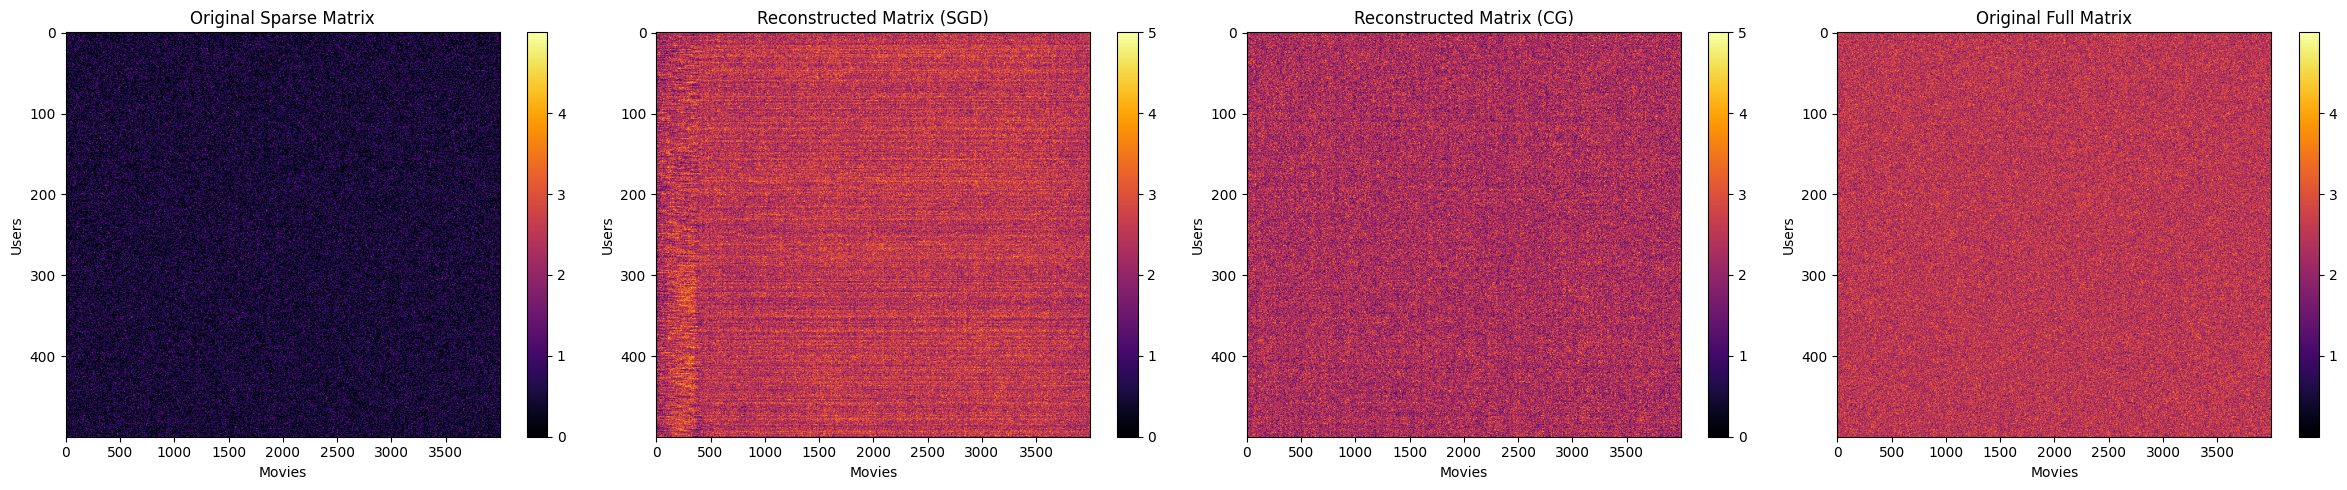

In [64]:
def plot_multiple_matrices(matrices, titles=None, figsize=(6, 5)):
    """
    Plots multiple matrices side by side.
    
    Parameters:
    - matrices: List of 2D numpy arrays (matrices to plot).
    - titles: List of titles corresponding to each matrix. If None, default titles are used.
    - figsize: Tuple indicating the figure size (width, height).
    """
    n = len(matrices)  # Number of matrices to plot

    if titles is None:
        titles = [f"Matrix {i+1}" for i in range(n)]  # Default titles if not provided

    plt.figure(figsize=(figsize[0] * n, figsize[1] ))  # Adjust figure size dynamically
    
    for i, matrix in enumerate(matrices):
        plt.subplot(1, n, i + 1)  # Create subplot for each matrix
        plt.imshow(matrix, aspect='auto', cmap='inferno')
        plt.title(titles[i])
        plt.colorbar()
        plt.xlabel("Movies")
        plt.ylabel("Users")

    plt.tight_layout()
    plt.show()

original = np.nan_to_num(mf_movies.synthetic_sparse, nan=0)
R_clip = np.clip(p @ (q.T), 0, 5)
R_clip_ = np.clip(p_nnls @ (q_nnls.T), 0, 5)

plot_multiple_matrices(
    matrices=[original, R_clip , R_clip_ , f],
    titles=["Original Sparse Matrix", "Reconstructed Matrix (SGD)", "Reconstructed Matrix (CG)" , "Original Full Matrix"]
)


In [ ]:
def calculate_match_percentage(matrix1, matrix2):
    """
    Calculate the percentage of matches between two matrices.
    A match is defined as both entries falling within the same range [N, N+1.5), 
    where N is an integer from 0 to 3.
    
    Parameters:
    - matrix1: First matrix (numpy array)
    - matrix2: Second matrix (numpy array)
    
    Returns:
    - Percentage of matches (float)
    """
    # Ensure both matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape!")
    
    # Calculate the range indices for each matrix
    ranges1 = np.floor(matrix1 / 1.5).astype(int)
    ranges2 = np.floor(matrix2 / 1.5).astype(int)
    
    # Apply the condition: both values must fall within [N, N+1.5)
    valid_ranges = (ranges1 >= 0) & (ranges1 <= 3) & (ranges2 >= 0) & (ranges2 <= 3)
    matches = (ranges1 == ranges2) & valid_ranges

    # Calculate match percentage
    total_valid = np.sum(valid_ranges)  # Total number of valid comparisons
    total_matches = np.sum(matches)    # Total number of matches

    if total_valid == 0:
        return 0.0  # Avoid division by zero
    
    return (total_matches / total_valid) * 100


match_percentage = calculate_match_percentage(R_clip, f)
print(f"Match Percentage: {match_percentage:.2f}%")


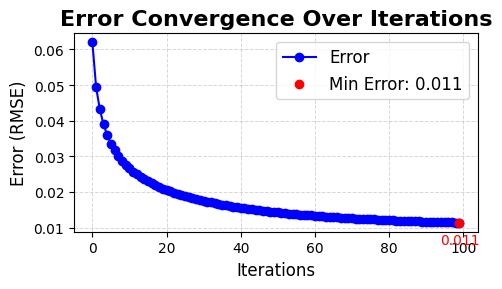

In [94]:
# Create the plot
plt.figure(figsize=(5, 3))
plt.plot(range(len(e)), e, marker='o', linestyle='-', color='blue', label='Error')

# Add title and labels
plt.title("Error Convergence Over Iterations", fontsize=16, fontweight='bold')
plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Error (RMSE)", fontsize=12)

# Highlight the minimum error
min_error_idx = e.index(min(e))
plt.scatter(min_error_idx, e[min_error_idx], color='red', zorder=5, label=f'Min Error: {e[min_error_idx]:.3f}')
plt.annotate(f"{e[min_error_idx]:.3f}", (min_error_idx, e[min_error_idx]),
             textcoords="offset points", xytext=(0, -15), ha='center', color='red', fontsize=10)

# Add grid, legend, and adjust styling
plt.grid(alpha=0.5, linestyle='--', linewidth=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

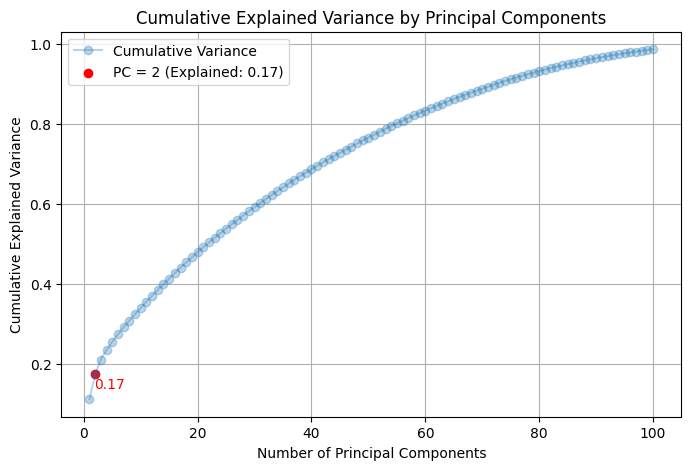

In [47]:
# Apply PCA to latent vectors
pca = PCA(n_components=100)  # Adjust to fit the number of features
pca.fit(P)  # Replace P with Q for item latent factors

# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, 101), cumulative_variance, marker='o', alpha=0.3, label="Cumulative Variance")

# Highlight the point where number of components = 2
x_highlight = 2
y_highlight = cumulative_variance[x_highlight - 1]  # Index is 1-based for components

plt.scatter(x_highlight, y_highlight, color='red', label=f"PC = {x_highlight} (Explained: {y_highlight:.2f})")

# Add annotations
plt.annotate(
    f"{y_highlight:.2f}",
    (x_highlight, y_highlight),
    textcoords="offset points",
    xytext=(10, -10),
    ha='center',
    color='red'
)

# Add titles and labels
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.show()



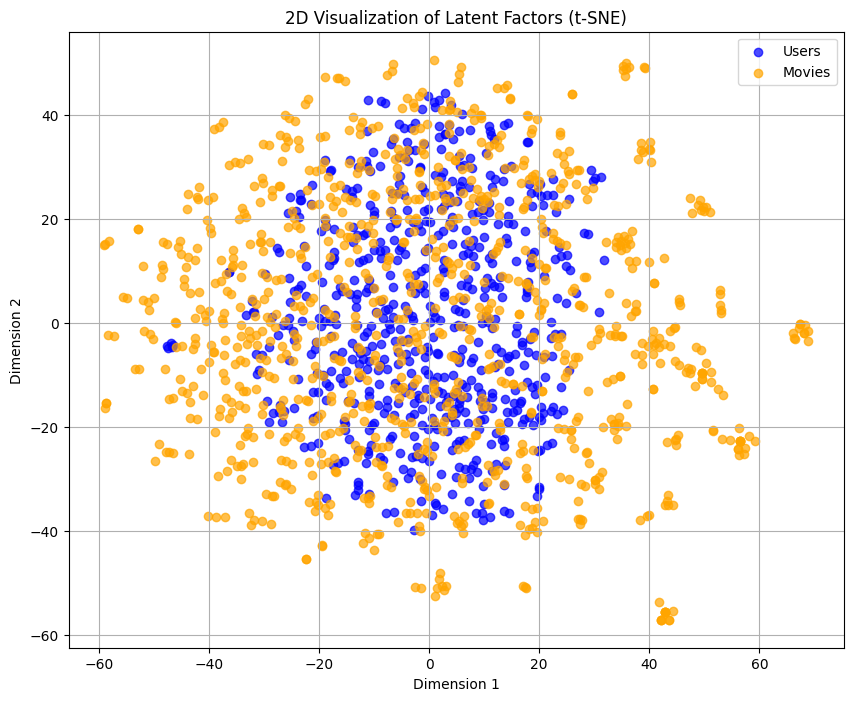

In [46]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
reduced_P = tsne.fit_transform(P)  # User latent factors
reduced_Q = tsne.fit_transform(Q)  # Item latent factors

# Plot latent factors in 2D
plt.figure(figsize=(10, 8))
plt.scatter(reduced_P[:, 0], reduced_P[:, 1], alpha=0.7, label="Users", c='blue')
plt.scatter(reduced_Q[:, 0], reduced_Q[:, 1], alpha=0.7, label="Movies", c='orange')

plt.title("2D Visualization of Latent Factors (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

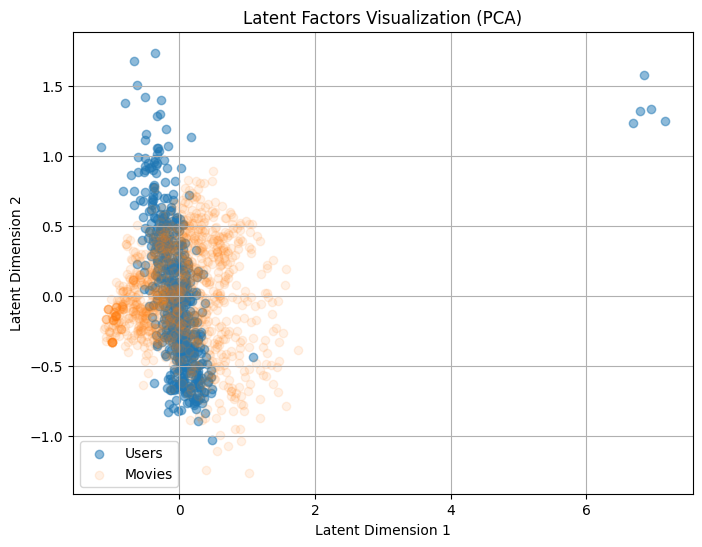

In [45]:

# Reduce latent dimensions for visualization
pca = PCA(n_components=2)
reduced_P = pca.fit_transform(P)  # User latent factors
reduced_Q = pca.fit_transform(Q)  # Movie latent factors

# Plot latent factors
plt.figure(figsize=(8, 6))
plt.scatter(reduced_P[:, 0], reduced_P[:, 1], label="Users", alpha=0.5)
plt.scatter(reduced_Q[:, 0], reduced_Q[:, 1], label="Movies", alpha=0.1)
plt.title("Latent Factors Visualization (PCA)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Reduce user (P) and item (Q) latent factors to 3 dimensions
pca = PCA(n_components=3)
reduced_P = pca.fit_transform(P)  # User latent factors
reduced_Q = pca.fit_transform(Q)  # Item latent factors

# Combine data into a single DataFrame for visualization
user_data = pd.DataFrame(reduced_P, columns=["Dim1", "Dim2", "Dim3"])
user_data["Type"] = "User"  # Label as users

movie_data = pd.DataFrame(reduced_Q, columns=["Dim1", "Dim2", "Dim3"])
movie_data["Type"] = "Movie"  # Label as movies

# Combine users and movies
combined_data = pd.concat([user_data, movie_data], ignore_index=True)

# Create an interactive 3D scatter plot
fig = px.scatter_3d(
    combined_data,
    x="Dim1",
    y="Dim2",
    z="Dim3",
    color="Type",  # Different colors for users and movies
    opacity=0.7,
    title="Interactive 3D Visualization of Latent Factors",
    labels={"Type": "Entity Type"}
)

# Show the interactive plot
fig.show()
